In [2]:
#!unzip nfl-big-data-bowl-2026-prediction.zip

Archive:  nfl-big-data-bowl-2026-prediction.zip
  inflating: kaggle_evaluation/__init__.py  
  inflating: kaggle_evaluation/core/__init__.py  
  inflating: kaggle_evaluation/core/base_gateway.py  
  inflating: kaggle_evaluation/core/generated/__init__.py  
  inflating: kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py  
  inflating: kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py  
  inflating: kaggle_evaluation/core/kaggle_evaluation.proto  
  inflating: kaggle_evaluation/core/relay.py  
  inflating: kaggle_evaluation/core/templates.py  
  inflating: kaggle_evaluation/nfl_gateway.py  
  inflating: kaggle_evaluation/nfl_inference_server.py  
  inflating: test.csv                
  inflating: test_input.csv          
  inflating: train/input_2023_w01.csv  
  inflating: train/input_2023_w02.csv  
  inflating: train/input_2023_w03.csv  
  inflating: train/input_2023_w04.csv  
  inflating: train/input_2023_w05.csv  
  inflating: train/input_2023_w06.csv  
  inflating

In [3]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
import glob
import os

# --- CONFIGURATION ---
INPUT_FILES = sorted(glob.glob("train/input_*.csv"))
DATASET_FILE = 'nfl_attention_dataset_CLEAN.pt' # Nouveau nom "CLEAN"
FUTURE_WINDOW = 10

data_list = []

print(f"📂 Traitement des fichiers : {INPUT_FILES}")

for input_file in INPUT_FILES:
    output_file = input_file.replace("input_", "output_")
    if not os.path.exists(output_file): continue

    print(f"🔄 Traitement {input_file}...")
    df_in = pd.read_csv(input_file)
    df_out = pd.read_csv(output_file)

    grouped = df_in.groupby(['game_id', 'play_id', 'frame_id'])

    for (game_id, play_id, frame_id), group in tqdm(grouped):
        # A. Receveur (Query)
        rec_row = group[group['player_role'] == 'Targeted Receiver']
        if len(rec_row) != 1: continue

        rx, ry = rec_row['x'].values[0], rec_row['y'].values[0]
        rec_id = rec_row['nfl_id'].values[0]
        play_dir = rec_row['play_direction'].values[0]

        # B. Label (Output)
        future_frame = frame_id + FUTURE_WINDOW
        future_pos = df_out[
            (df_out['game_id'] == game_id) &
            (df_out['play_id'] == play_id) &
            (df_out['nfl_id'] == rec_id) &
            (df_out['frame_id'] == future_frame)
        ]

        if len(future_pos) == 0: continue

        # Calcul du déplacement BRUT
        raw_dx = future_pos['x'].values[0] - rx
        raw_dy = future_pos['y'].values[0] - ry

        # CORRECTION CRUCIALE : Si le jeu est à gauche, on inverse le déplacement
        # Pour que "Avancer" soit toujours positif dans le référentiel du modèle
        if play_dir == 'left':
            label_dx = -raw_dx
            label_dy = -raw_dy
        else:
            label_dx = raw_dx
            label_dy = raw_dy

        label_tensor = torch.tensor([label_dx, label_dy], dtype=torch.float32)

        # C. Query Tensor (Standardisé)
        ball_x = rec_row['ball_land_x'].values[0]
        ball_y = rec_row['ball_land_y'].values[0]
        rec_s = rec_row['s'].values[0]
        rec_dir = rec_row['dir'].values[0]

        if play_dir == 'left':
            ball_x = 120 - ball_x
            ball_y = 53.3 - ball_y
            rx_std = 120 - rx
            ry_std = 53.3 - ry
            rec_dir = (rec_dir + 180) % 360
        else:
            rx_std = rx
            ry_std = ry
            # rec_dir reste tel quel

        q_feats = [rec_s, rec_dir, ball_x - rx_std, ball_y - ry_std]
        query_tensor = torch.tensor(q_feats, dtype=torch.float32)

        # D. Keys (Défenseurs Standardisés)
        defenders = group[group['player_side'] == 'Defense']
        if len(defenders) == 0: continue

        def_list = []
        for _, d in defenders.iterrows():
            dx, dy = d['x'], d['y']
            ds, ddir = d['s'], d['dir']

            if play_dir == 'left':
                dx = 120 - dx
                dy = 53.3 - dy
                ddir = (ddir + 180) % 360

            d_feats = [dx - rx_std, dy - ry_std, ds, ddir]
            def_list.append(d_feats)

        keys_tensor = torch.tensor(def_list, dtype=torch.float32)

        # Padding
        if keys_tensor.shape[0] < 11:
            padding = torch.zeros((11 - keys_tensor.shape[0], 4))
            keys_tensor = torch.cat([keys_tensor, padding], dim=0)
        else:
            keys_tensor = keys_tensor[:11]

        data_list.append((query_tensor, keys_tensor, label_tensor))

# --- SAUVEGARDE ---
print("\n📦 Sauvegarde...")
final_queries = torch.stack([x[0] for x in data_list])
final_keys = torch.stack([x[1] for x in data_list])
final_labels = torch.stack([x[2] for x in data_list])

dataset = {
    'queries': final_queries,
    'keys': final_keys,
    'labels': final_labels
}
torch.save(dataset, DATASET_FILE)
print("✅ Dataset CLEAN généré !")

📂 Traitement des fichiers : ['train/input_2023_w01.csv', 'train/input_2023_w02.csv', 'train/input_2023_w03.csv', 'train/input_2023_w04.csv', 'train/input_2023_w05.csv', 'train/input_2023_w06.csv', 'train/input_2023_w07.csv', 'train/input_2023_w08.csv', 'train/input_2023_w09.csv', 'train/input_2023_w10.csv', 'train/input_2023_w11.csv', 'train/input_2023_w12.csv', 'train/input_2023_w13.csv', 'train/input_2023_w14.csv', 'train/input_2023_w15.csv', 'train/input_2023_w16.csv', 'train/input_2023_w17.csv', 'train/input_2023_w18.csv']
🔄 Traitement train/input_2023_w01.csv...


100%|██████████| 23151/23151 [00:40<00:00, 578.45it/s]


🔄 Traitement train/input_2023_w02.csv...


100%|██████████| 23303/23303 [00:38<00:00, 606.71it/s]


🔄 Traitement train/input_2023_w03.csv...


100%|██████████| 24393/24393 [00:42<00:00, 570.67it/s]


🔄 Traitement train/input_2023_w04.csv...


100%|██████████| 22058/22058 [00:38<00:00, 568.86it/s]


🔄 Traitement train/input_2023_w05.csv...


100%|██████████| 20838/20838 [00:35<00:00, 579.29it/s]


🔄 Traitement train/input_2023_w06.csv...


100%|██████████| 22057/22057 [00:37<00:00, 592.63it/s]


🔄 Traitement train/input_2023_w07.csv...


100%|██████████| 19093/19093 [00:32<00:00, 588.55it/s]


🔄 Traitement train/input_2023_w08.csv...


100%|██████████| 22831/22831 [00:38<00:00, 594.02it/s]


🔄 Traitement train/input_2023_w09.csv...


100%|██████████| 20358/20358 [00:33<00:00, 606.52it/s]


🔄 Traitement train/input_2023_w10.csv...


100%|██████████| 20978/20978 [00:35<00:00, 595.24it/s]


🔄 Traitement train/input_2023_w11.csv...


100%|██████████| 19744/19744 [00:31<00:00, 617.59it/s]


🔄 Traitement train/input_2023_w12.csv...


100%|██████████| 24018/24018 [00:43<00:00, 546.56it/s]


🔄 Traitement train/input_2023_w13.csv...


100%|██████████| 19077/19077 [00:31<00:00, 604.78it/s]


🔄 Traitement train/input_2023_w14.csv...


100%|██████████| 22734/22734 [00:39<00:00, 576.22it/s]


🔄 Traitement train/input_2023_w15.csv...


100%|██████████| 22926/22926 [00:38<00:00, 598.95it/s]


🔄 Traitement train/input_2023_w16.csv...


100%|██████████| 25831/25831 [00:44<00:00, 581.05it/s]


🔄 Traitement train/input_2023_w17.csv...


100%|██████████| 22676/22676 [00:41<00:00, 545.81it/s]


🔄 Traitement train/input_2023_w18.csv...


100%|██████████| 20848/20848 [00:35<00:00, 586.57it/s]



📦 Sauvegarde...
✅ Dataset CLEAN généré !


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NFLAttentionModel(nn.Module):
    def __init__(self, receiver_dim=4, defender_dim=4, embed_dim=64, num_heads=4):
        super().__init__()

        # 1. Embeddings Spécifiques (C'est la nouveauté)
        # On projette le Receveur dans l'espace latent
        self.receiver_embedding = nn.Linear(receiver_dim, embed_dim)

        # On projette les Défenseurs dans le MÊME espace latent
        self.defender_embedding = nn.Linear(defender_dim, embed_dim)

        # 2. Multi-Head Attention (Le Cœur)
        # batch_first=True pour avoir (Batch, Seq, Features)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        # 3. Tête de prédiction (Régression)
        # On prédit la "Distance au ballon" (puisque c'est ce qu'on a mis dans le dataset)
        # Si la distance prédite est petite, c'est que l'action est un succès.
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
            # Pas de Sigmoid car on prédit une distance (en yards), pas une proba 0-1
        )

    def forward(self, receiver_data, defenders_data):
        # receiver_data: (Batch, 4) -> (Vitesse, Dir, DistBallX, DistBallY)
        # defenders_data: (Batch, 11, 4) -> (RelX, RelY, Vitesse, Dir)

        # A. Projection (Embeddings)
        # On ajoute une dimension "Séquence=1" au receveur pour qu'il devienne (Batch, 1, Embed)
        query = self.receiver_embedding(receiver_data).unsqueeze(1)

        # Les défenseurs sont déjà une séquence de 11, donc (Batch, 11, Embed)
        keys = self.defender_embedding(defenders_data)
        values = keys # Les valeurs sont les mêmes que les clés (Standard)

        # B. Calcul de l'Attention
        # attn_weights sera de forme (Batch, 1, 11)
        # C'est TA MÉTRIQUE : L'importance de chaque défenseur
        attn_output, attn_weights = self.attention(query, keys, values)

        # C. Prédiction
        # On retire la dimension séquence pour passer dans le régresseur
        prediction = self.regressor(attn_output.squeeze(1))

        return prediction, attn_weights

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# 1. Classe Dataset Intelligente (Normalisation)
class NFLDataset(Dataset):
    def __init__(self, pt_file):
        data = torch.load(pt_file)
        self.queries = data['queries']
        self.keys = data['keys']
        self.labels = data['labels']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        q = self.queries[idx].clone()
        k = self.keys[idx].clone()
        y = self.labels[idx].clone()

        # --- NORMALISATION ---
        # Query: [Speed, Dir, DistX, DistY]
        q[0] /= 10.0   # Speed (max ~10)
        q[1] /= 360.0  # Dir
        q[2] /= 50.0   # DistX (max ~50)
        q[3] /= 50.0   # DistY

        # Keys: [RelX, RelY, Speed, Dir]
        k[:, 0] /= 50.0
        k[:, 1] /= 50.0
        k[:, 2] /= 10.0
        k[:, 3] /= 360.0

        # Label: [dX, dY] (Déplacement sur 10 frames, env 10 yards max)
        y /= 10.0

        return q, k, y

🚀 Entraînement avec Normalisation...
Epoch 1 | Loss: 0.2940 | Erreur estimée: 5.42 yards
Epoch 2 | Loss: 0.0849 | Erreur estimée: 2.91 yards
Epoch 3 | Loss: 0.0785 | Erreur estimée: 2.80 yards
Epoch 4 | Loss: 0.0763 | Erreur estimée: 2.76 yards
Epoch 5 | Loss: 0.0743 | Erreur estimée: 2.73 yards
Epoch 6 | Loss: 0.0732 | Erreur estimée: 2.70 yards
Epoch 7 | Loss: 0.0720 | Erreur estimée: 2.68 yards
Epoch 8 | Loss: 0.0716 | Erreur estimée: 2.68 yards
Epoch 9 | Loss: 0.0708 | Erreur estimée: 2.66 yards
Epoch 10 | Loss: 0.0705 | Erreur estimée: 2.65 yards
Epoch 11 | Loss: 0.0702 | Erreur estimée: 2.65 yards
Epoch 12 | Loss: 0.0694 | Erreur estimée: 2.64 yards
Epoch 13 | Loss: 0.0693 | Erreur estimée: 2.63 yards
Epoch 14 | Loss: 0.0689 | Erreur estimée: 2.63 yards
Epoch 15 | Loss: 0.0688 | Erreur estimée: 2.62 yards
Epoch 16 | Loss: 0.0688 | Erreur estimée: 2.62 yards
Epoch 17 | Loss: 0.0676 | Erreur estimée: 2.60 yards
Epoch 18 | Loss: 0.0678 | Erreur estimée: 2.60 yards
Epoch 19 | Loss: 0

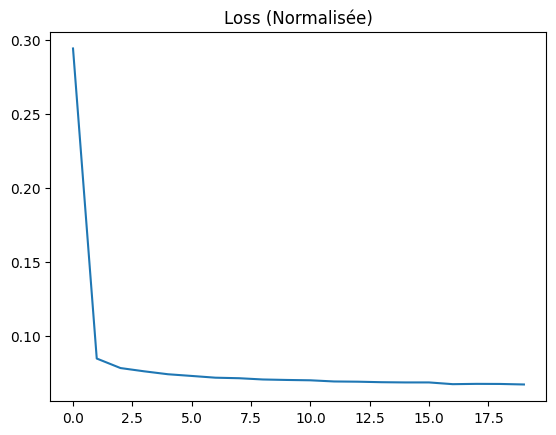

In [7]:
# 2. Chargement
dataset = NFLDataset('nfl_attention_dataset_CLEAN.pt')
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# 3. Modèle (Assure-toi d'avoir la classe NFLAttentionModel définie)
# embed_dim=128 donne plus de capacité
model = NFLAttentionModel(receiver_dim=4, defender_dim=4, embed_dim=128)

optimizer = optim.Adam(model.parameters(), lr=0.0005) # Learning rate plus doux
criterion = nn.MSELoss()

# 4. Entraînement
print("🚀 Entraînement avec Normalisation...")
losses = []

model.train()
for epoch in range(20):
    total_loss = 0
    for q, k, y in train_loader:
        optimizer.zero_grad()
        preds, _ = model(q, k)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)

    # La loss sera maintenant très petite (ex: 0.05) car tout est divisé
    # Pour avoir l'erreur en Yards, on remultiplie par 10 (l'échelle du label)
    # MSE -> RMSE -> * 10
    rmse_yards = (avg_loss**0.5) * 10.0

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Erreur estimée: {rmse_yards:.2f} yards")

plt.plot(losses)
plt.title("Loss (Normalisée)")
plt.show()

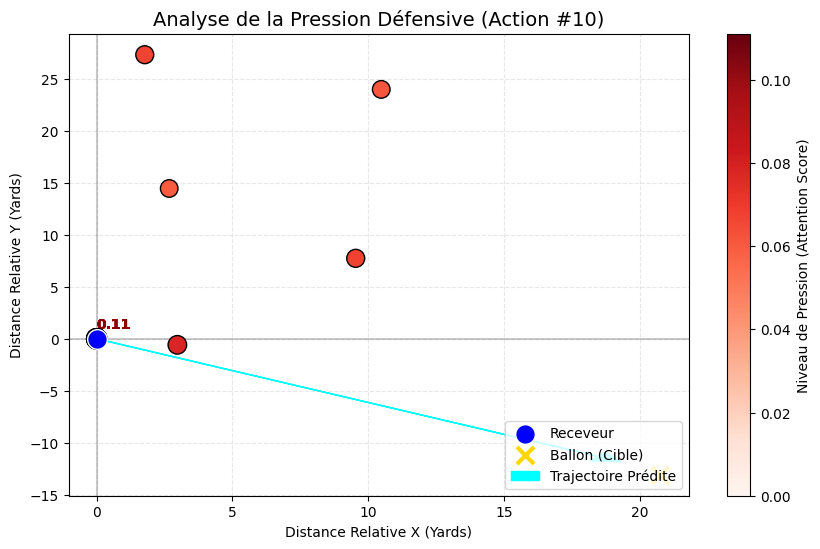

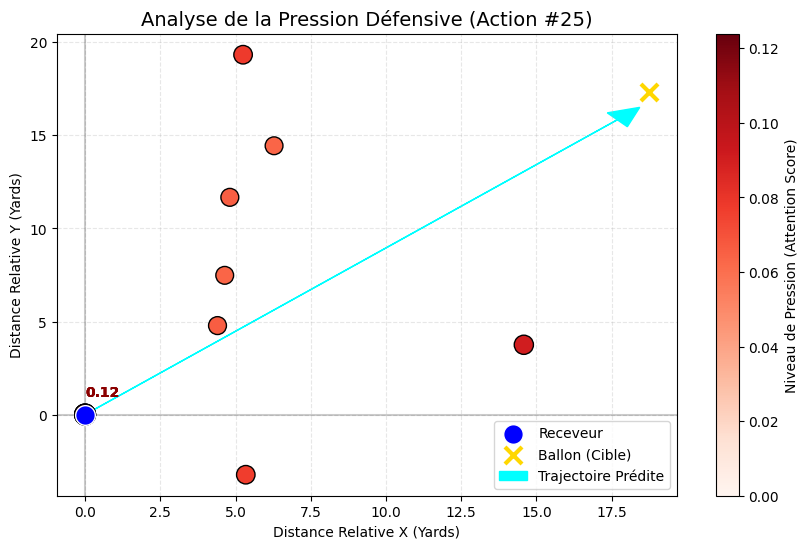

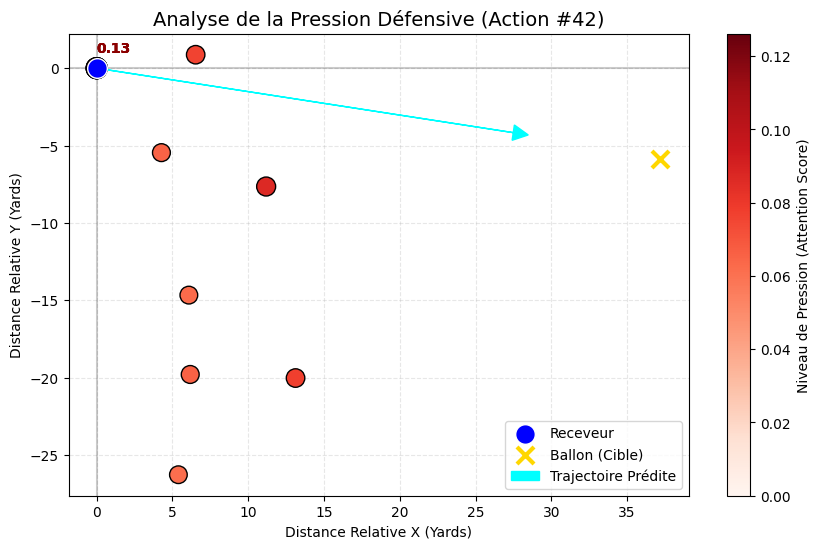

In [ ]:
import matplotlib.patches as patches

def analyze_play(idx):
    # Récupérer les données brutes (avant normalisation pour l'affichage)
    raw_data = torch.load('nfl_attention_dataset_CLEAN.pt')
    q_raw = raw_data['queries'][idx]
    k_raw = raw_data['keys'][idx]

    # Préparer les données pour le modèle (AVEC normalisation)
    q_norm = q_raw.clone()
    k_norm = k_raw.clone()

    q_norm[0] /= 13.0
    q_norm[1] /= 360.0
    q_norm[2] /= 50.0
    q_norm[3] /= 50.0

    k_norm[:, 0] /= 50.0
    k_norm[:, 1] /= 50.0
    k_norm[:, 2] /= 13.0
    k_norm[:, 3] /= 360.0

    # Ajouter la dimension Batch (1, ...)
    q_input = q_norm.unsqueeze(0)
    k_input = k_norm.unsqueeze(0)

    # --- PRÉDICTION ---
    model.eval()
    with torch.no_grad():
        preds, attn_weights = model(q_input, k_input)

    # Poids d'attention (L'importance de chaque défenseur)
    weights = attn_weights[0, 0, :].numpy()

    # --- DESSIN ---
    fig, ax = plt.subplots(figsize=(10, 6))

    # 1. Le Receveur (Toujours au centre 0,0 dans notre référentiel)
    ax.scatter(0, 0, c='blue', s=200, label='Receveur', zorder=5, edgecolors='white')

    # 2. Le Ballon (Cible)
    # Info stockée dans query [.., .., DistX, DistY]
    ball_x = q_raw[2].item()
    ball_y = q_raw[3].item()
    ax.scatter(ball_x, ball_y, c='gold', marker='x', s=150, linewidth=3, label='Ballon (Cible)')

    # 3. La Prédiction (Où l'IA pense que le receveur va aller)
    pred_dx = preds[0, 0].item() * 10.0
    pred_dy = preds[0, 1].item() * 10.0
    ax.arrow(0, 0, pred_dx, pred_dy, head_width=1, head_length=1, fc='cyan', ec='cyan', label='Trajectoire Prédite')

    # 4. Les Défenseurs (Colorés selon l'Attention)
    # Info stockée dans keys [RelX, RelY, ..]
    def_x = k_raw[:, 0].numpy()
    def_y = k_raw[:, 1].numpy()

    sc = ax.scatter(def_x, def_y, c=weights, cmap='Reds', s=100 + (weights*1000),
                    edgecolors='black', zorder=4, vmin=0, vmax=max(weights.max(), 0.1))

    # Afficher le score au dessus des défenseurs importants
    for i, w in enumerate(weights):
        if w > 0.10: # Seuil d'affichage
            ax.text(def_x[i], def_y[i]+1, f"{w:.2f}", fontsize=10, fontweight='bold', color='darkred')

    # Mise en page
    plt.colorbar(sc, label="Niveau de Pression (Attention Score)")
    ax.set_title(f"Analyse de la Pression Défensive (Action #{idx})", fontsize=14)
    ax.set_xlabel("Distance Relative X (Yards)")
    ax.set_ylabel("Distance Relative Y (Yards)")
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.axhline(0, color='black', alpha=0.2)
    ax.axvline(0, color='black', alpha=0.2)
    ax.legend(loc='lower right')

    plt.show()

# --- TEST ---
# Essaye plusieurs index pour trouver une belle action !
analyze_play(10)
analyze_play(25)
analyze_play(42)

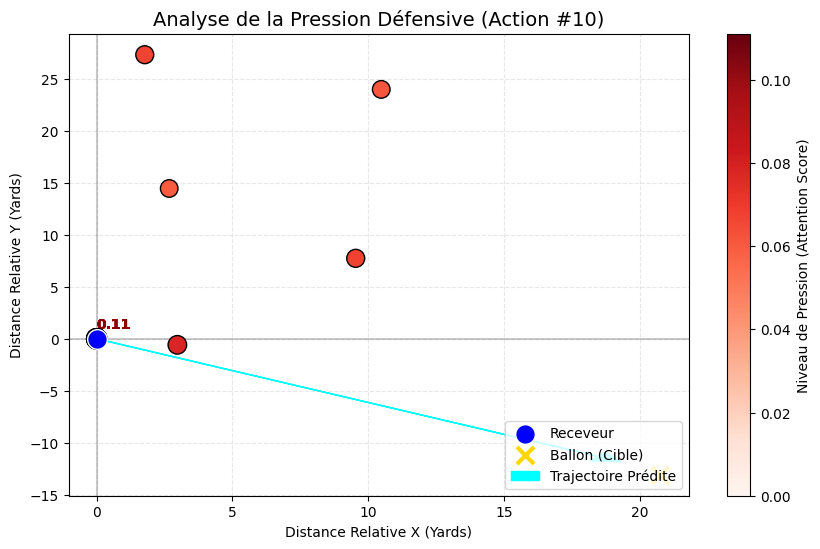

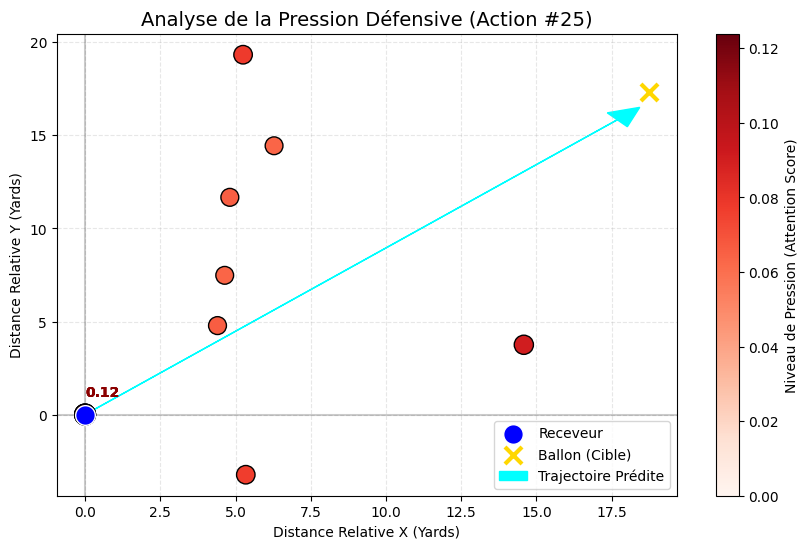

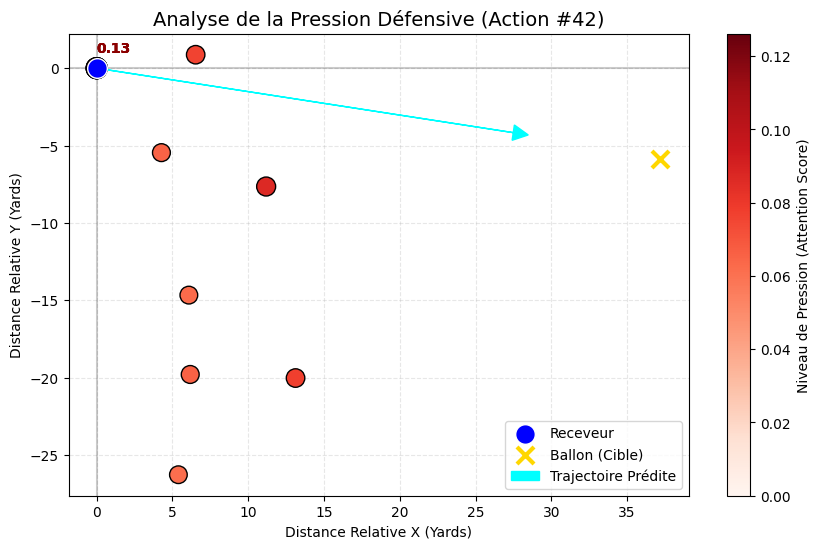

In [ ]:
import matplotlib.patches as patches

def analyze_play(idx):
    # Récupérer les données brutes (avant normalisation pour l'affichage)
    raw_data = torch.load('nfl_attention_dataset_CLEAN.pt')
    q_raw = raw_data['queries'][idx]
    k_raw = raw_data['keys'][idx]

    # Préparer les données pour le modèle (AVEC normalisation)
    q_norm = q_raw.clone()
    k_norm = k_raw.clone()

    q_norm[0] /= 13.0
    q_norm[1] /= 360.0
    q_norm[2] /= 50.0
    q_norm[3] /= 50.0

    k_norm[:, 0] /= 50.0
    k_norm[:, 1] /= 50.0
    k_norm[:, 2] /= 13.0
    k_norm[:, 3] /= 360.0

    # Ajouter la dimension Batch (1, ...)
    q_input = q_norm.unsqueeze(0)
    k_input = k_norm.unsqueeze(0)

    # --- PRÉDICTION ---
    model.eval()
    with torch.no_grad():
        preds, attn_weights = model(q_input, k_input)

    # Poids d'attention (L'importance de chaque défenseur)
    weights = attn_weights[0, 0, :].numpy()

    # --- DESSIN ---
    fig, ax = plt.subplots(figsize=(10, 6))

    # 1. Le Receveur (Toujours au centre 0,0 dans notre référentiel)
    ax.scatter(0, 0, c='blue', s=200, label='Receveur', zorder=5, edgecolors='white')

    # 2. Le Ballon (Cible)
    # Info stockée dans query [.., .., DistX, DistY]
    ball_x = q_raw[2].item()
    ball_y = q_raw[3].item()
    ax.scatter(ball_x, ball_y, c='gold', marker='x', s=150, linewidth=3, label='Ballon (Cible)')

    # 3. La Prédiction (Où l'IA pense que le receveur va aller)
    pred_dx = preds[0, 0].item() * 10.0
    pred_dy = preds[0, 1].item() * 10.0
    ax.arrow(0, 0, pred_dx, pred_dy, head_width=1, head_length=1, fc='cyan', ec='cyan', label='Trajectoire Prédite')

    # 4. Les Défenseurs (Colorés selon l'Attention)
    # Info stockée dans keys [RelX, RelY, ..]
    def_x = k_raw[:, 0].numpy()
    def_y = k_raw[:, 1].numpy()

    sc = ax.scatter(def_x, def_y, c=weights, cmap='Reds', s=100 + (weights*1000),
                    edgecolors='black', zorder=4, vmin=0, vmax=max(weights.max(), 0.1))

    # Afficher le score au dessus des défenseurs importants
    for i, w in enumerate(weights):
        if w > 0.10: # Seuil d'affichage
            ax.text(def_x[i], def_y[i]+1, f"{w:.2f}", fontsize=10, fontweight='bold', color='darkred')

    # Mise en page
    plt.colorbar(sc, label="Niveau de Pression (Attention Score)")
    ax.set_title(f"Analyse de la Pression Défensive (Action #{idx})", fontsize=14)
    ax.set_xlabel("Distance Relative X (Yards)")
    ax.set_ylabel("Distance Relative Y (Yards)")
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.axhline(0, color='black', alpha=0.2)
    ax.axvline(0, color='black', alpha=0.2)
    ax.legend(loc='lower right')

    plt.show()

# --- TEST ---
# Essaye plusieurs index pour trouver une belle action !
analyze_play(10)
analyze_play(25)
analyze_play(42)

/tmp/ipython-input-607568629.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  play_in['type'] = 'input'


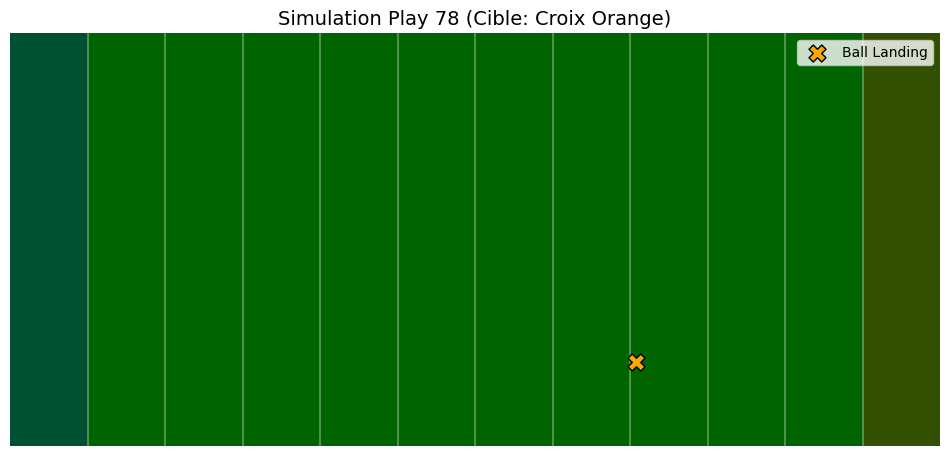

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

# 1. CHARGEMENT ET FILTRAGE DU FICHIER
# Assurez-vous que le fichier est dans le même dossier
df = pd.read_csv('train/input_2023_w16.csv')
df_out = pd.read_csv('train/output_2023_w16.csv')

# Choix du play à simuler (Ex: Match 2023122100, Play 78)
game_id_choisi = 2023122100
play_id_choisi = 78

play_in = df[(df['game_id'] == game_id_choisi) & (df['play_id'] == play_id_choisi)]
play_out = df_out[(df_out['game_id'] == game_id_choisi) & (df_out['play_id'] == play_id_choisi)].copy()

max_input_frame = play_in['frame_id'].max()
play_out['frame_id'] = play_out['frame_id'] + max_input_frame

cols_to_merge = ['nfl_id', 'player_name', 'player_role', 'player_side', 'player_position']
player_meta = play_in[cols_to_merge].drop_duplicates()
play_out = play_out.merge(player_meta, on='nfl_id', how='left')

# Création du dataset complet combiné
# On ajoute une colonne 'type' pour distinguer input/output visuellement si besoin
play_in['type'] = 'input'
play_out['type'] = 'output'
full_play = pd.concat([play_in, play_out], ignore_index=True)

# Récupération de la cible (Output)
target_x = full_play['ball_land_x'].iloc[0]
target_y = full_play['ball_land_y'].iloc[0]

# --- FONCTION DE DESSIN DU TERRAIN ---
def create_football_field(ax):
    # Fond vert
    ax.set_facecolor('darkgreen')
    ax.add_patch(patches.Rectangle((0, 0), 120, 53.3, facecolor='darkgreen', zorder=0))

    # Lignes (tous les 10 yards)
    for x in range(10, 111, 10):
        ax.axvline(x, color='white', linestyle='-', alpha=0.3)

    # Endzones (0-10 et 110-120)
    ax.add_patch(patches.Rectangle((0, 0), 10, 53.3, facecolor='blue', alpha=0.2))
    ax.add_patch(patches.Rectangle((110, 0), 10, 53.3, facecolor='red', alpha=0.2))

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_aspect('equal')
    ax.axis('off')

# --- CONFIGURATION DE L'ANIMATION ---
fig, ax = plt.subplots(figsize=(12, 6))
create_football_field(ax)
ax.set_title(f"Simulation Play {play_id_choisi} (Cible: Croix Orange)", color='black', fontsize=14)

# Marquer la zone de chute du ballon (Output)
ax.scatter(target_x, target_y, marker='X', s=150, color='orange', edgecolors='black', label='Ball Landing', zorder=2)

# Initialisation des points pour les joueurs
scatters = {}
# On sépare par rôles pour les couleurs
roles_colors = {
    'Passer': 'yellow',
    'Targeted Receiver': 'cyan',
    'Defensive Coverage': 'red',
    'Other Route Runner': 'blue' # Ou autres rôles offensifs
}

groups = full_play.groupby('nfl_id')
player_plots = {}

for nfl_id, group in groups:
    role = group['player_role'].iloc[0]
    side = group['player_side'].iloc[0]

    # Couleur par défaut : Rouge (Defense) ou Bleu (Offense)
    color = 'red' if side == 'Defense' else 'blue'

    # Couleurs spéciales pour les rôles clés
    if role in roles_colors:
        color = roles_colors[role]

    # Créer le point (scatter) et le texte (nom)
    scat = ax.scatter([], [], color=color, s=80, edgecolors='white', zorder=5)
    text = ax.text(0, 0, '', color='white', fontsize=8, fontweight='bold')
    player_plots[nfl_id] = (scat, text, group)

# Fonction de mise à jour image par image
def update(frame_num):
    # frame_num commence à 0, mais vos frame_id commencent souvent à 1
    current_frame_id = frame_num + 1

    for nfl_id, (scat, text, group) in player_plots.items():
        # Trouver la ligne correspondant à cette frame
        data = group[group['frame_id'] == current_frame_id]

        if not data.empty:
            x = data['x'].values[0]
            y = data['y'].values[0]
            name = data['player_name'].values[0]

            scat.set_offsets([[x, y]])
            text.set_position((x, y + 1.5)) # Texte un peu au dessus
            text.set_text(name)
        else:
            # Si pas de donnée pour ce joueur à cette frame (ex: sortie du champ)
            scat.set_offsets([[-10, -10]]) # Hors champ
            text.set_text('')

    return [p[0] for p in player_plots.values()] + [p[1] for p in player_plots.values()]

# Création de l'animation
frames_total = full_play['frame_id'].max()
ani = animation.FuncAnimation(fig, update, frames=frames_total, interval=100, blit=False)

plt.legend(loc='upper right')
plt.show()

# Pour sauvegarder en vidéo (nécessite ffmpeg) :
ani.save('simulation_nfl.mp4', writer='ffmpeg', fps=2)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

# 1. CHARGEMENT
df_in = pd.read_csv('train/input_2023_w16.csv')
df_out = pd.read_csv('train/output_2023_w16.csv')

# Paramètres
GAME_ID = 2023122100
PLAY_ID = 78

# Filtrage du Play
play_in = df_in[(df_in['game_id'] == GAME_ID) & (df_in['play_id'] == PLAY_ID)].copy()
play_out = df_out[(df_out['game_id'] == GAME_ID) & (df_out['play_id'] == PLAY_ID)].copy()

# 2. ALIGNEMENT DES DONNÉES (INPUT + OUTPUT)
# On décale les frame_id de l'output pour qu'ils suivent l'input
max_input_frame = play_in['frame_id'].max()
play_out['frame_id'] = play_out['frame_id'] + max_input_frame

# Fusionner les infos des joueurs (rôle, nom) de l'input vers l'output
# car l'output n'a que x, y, nfl_id
cols_to_merge = ['nfl_id', 'player_name', 'player_role', 'player_side', 'player_position']
player_meta = play_in[cols_to_merge].drop_duplicates()
play_out = play_out.merge(player_meta, on='nfl_id', how='left')

# Création du dataset complet combiné
# On ajoute une colonne 'type' pour distinguer input/output visuellement si besoin
play_in['type'] = 'input'
play_out['type'] = 'output'
full_play = pd.concat([play_in, play_out], ignore_index=True)

# Application de la réduction de frames
frames_unique = sorted(full_play['frame_id'].unique())
full_play = full_play[full_play['frame_id']]

# --- ANIMATION ---
fig, ax = plt.subplots(figsize=(12, 6))

def setup_field():
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_facecolor('darkgreen')
    # Lignes, endzones... (code abrégé pour clarté)
    for x in range(10, 111, 10): ax.axvline(x, color='white', alpha=0.3)
    ax.axis('off')

setup_field()
ax.set_title(f"Play {PLAY_ID} (Input + Output)")

# Initialisation des scatters
scatters = {}
lines = {} # Pour tracer la traînée
groups = full_play.groupby('nfl_id')

for nfl_id, group in groups:
    role = group['player_role'].iloc[0]
    side = group['player_side'].iloc[0]

    # Couleurs
    if role == 'Targeted Receiver': color = 'cyan'
    elif role == 'Passer': color = 'yellow'
    elif side == 'Defense': color = 'red'
    else: color = 'blue'

    # Point actuel
    scat = ax.scatter([], [], color=color, s=80, edgecolors='white', zorder=5)
    # Traînée (Ligne)
    line, = ax.plot([], [], color=color, alpha=0.5, linewidth=1)

    scatters[nfl_id] = scat
    lines[nfl_id] = line

def update(frame_val):
    # frame_val est la frame_id réelle
    current_data = full_play[full_play['frame_id'] == frame_val]

    artists = []

    for nfl_id, player_row in current_data.iterrows():
        nid = player_row['nfl_id']
        x, y = player_row['x'], player_row['y']

        # Mise à jour point
        scatters[nid].set_offsets([[x, y]])
        artists.append(scatters[nid])

        # Mise à jour traînée (historique jusqu'à cette frame)
        # On récupère tout l'historique de ce joueur jusqu'à frame_val
        hist = full_play[(full_play['nfl_id'] == nid) & (full_play['frame_id'] <= frame_val)]
        lines[nid].set_data(hist['x'], hist['y'])

        # Changement de style si on passe dans la phase 'output' ?
        # Optionnel: on pourrait rendre la ligne pointillée si frame_val > max_input_frame

        artists.append(lines[nid])

    return artists

# --- AJUSTEMENT DE LA VITESSE ---
# interval=200 signifie 200ms entre chaque frame (soit 5 images/seconde).
# Plus ce chiffre est grand, plus l'animation est LENTE.
ani = animation.FuncAnimation(fig, update, interval=200, blit=True)

# Si vous sauvegardez en vidéo :
# fps=5 donnera une vidéo ralentie où l'on voit bien chaque mouvement.
# ani.save('ralenti_nfl.mp4', writer='ffmpeg', fps=5)